0 [68.88, 51.59, -15.89, -48.22, 2.25, -19.01, 56.76, -39.34, -4.68, 16.68]


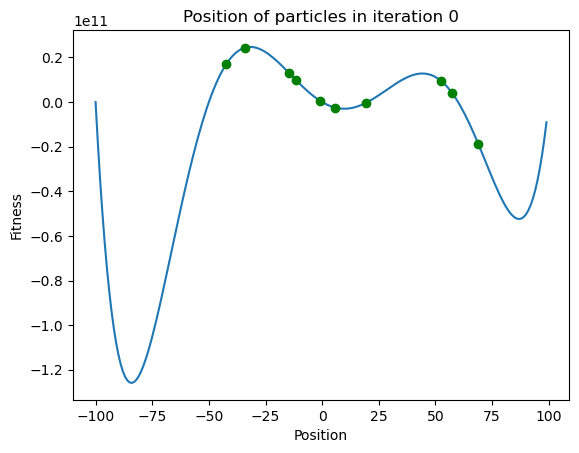

1 [68.88, 52.46, -11.61, -42.31, 5.62, -14.58, 57.37, -33.88, -0.97, 19.31]
2 [68.88, 54.58, -1.25, -28.16, 13.76, -3.83, 58.85, -20.8, 8.02, 25.62]
3 [68.88, 57.05, 10.87, -12.82, 23.29, 8.73, 60.59, -5.48, 18.54, 32.46]
4 [68.88, 60.69, 28.69, 7.33, 36.43, 27.21, 63.14, 17.15, 33.05, 41.44]
5 [68.88, 65.06, 48.69, 33.03, 50.66, 47.95, 66.2, 44.45, 48.76, 50.89]
6 [68.88, 69.71, 69.0, 60.55, 65.08, 69.0, 69.47, 72.68, 64.68, 60.6]
7 [69.14, 74.57, 89.55, 84.12, 80.01, 90.3, 72.95, 100, 81.15, 67.18]
8 [69.55, 79.52, 100, 100, 94.99, 100, 76.54, 100, 97.64, 73.93]
9 [70.85, 84.76, 100, 100, 100, 100, 80.6, 100, 100, 81.31]
10 [73.5, 89.99, 100, 100, 100, 100, 85.06, 100, 100, 89.02]
11 [77.14, 94.55, 100, 100, 100, 100, 89.52, 100, 100, 96.38]
12 [81.42, 98.09, 100, 100, 100, 100, 93.51, 100, 100, 100]
13 [85.71, 100, 100, 100, 100, 100, 97.02, 100, 100, 100]
14 [90.0, 100, 100, 100, 100, 100, 99.21, 100, 100, 100]
15 [93.65, 98.91, 100, 100, 100, 100, 99.34, 100, 100, 100]
16 [96.9, 9

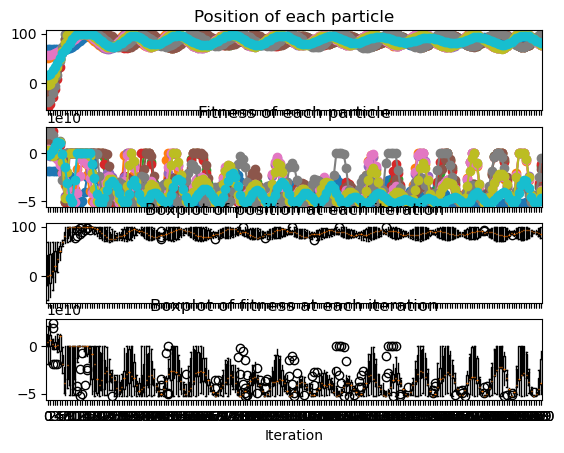

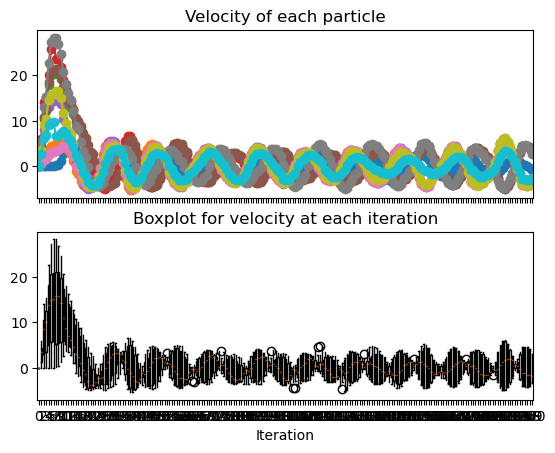

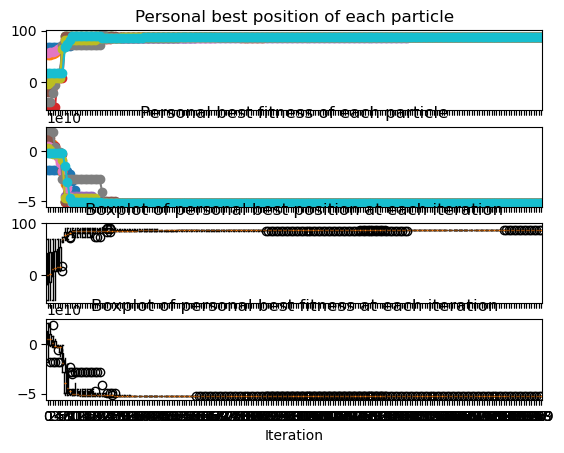

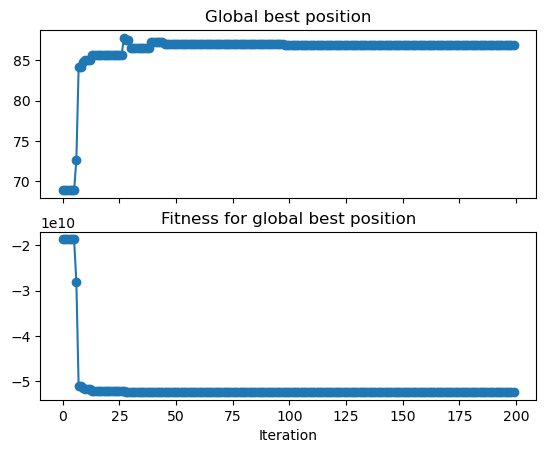

In [1]:
import random
import matplotlib.pyplot as plt

# ---------- Fitness function ----------

def fit_fcn(position):
    """
    f(x) = (x + 100)(x + 50)(x)(x - 20)(x - 60)(x - 100)
    """
    x = position
    return (x + 100) * (x + 50) * x * (x - 20) * (x - 60) * (x - 100)


# ---------- Particle class ----------

class Particle:
    def __init__(self, position=0.0, velocity=0.0):
        self.position = position
        self.velocity = velocity
        self.best_position = position  # personal best

        # for evaluation / plotting later
        self.position_list = [position]
        self.velocity_list = [velocity]
        self.best_position_list = []

    def update_personal_best(self):
        """
        Update personal best position if current position is better
        (i.e. has lower fitness value).
        """
        current_fit = fit_fcn(self.position)
        best_fit = fit_fcn(self.best_position)

        if current_fit < best_fit:
            self.best_position = self.position

        # record history
        self.best_position_list.append(self.best_position)

    def update_velocity(self, alpha, beta, glob_best_pos):
        """
        v = v + α1 β1 (p_best - x) + α2 β2 (g_best - x)
        alpha: [alpha1, alpha2]
        beta:  [beta1, beta2]  (random each iteration)
        """
        alpha1, alpha2 = alpha
        beta1, beta2 = beta

        cognitive = alpha1 * beta1 * (self.best_position - self.position)
        social = alpha2 * beta2 * (glob_best_pos - self.position)

        self.velocity = self.velocity + cognitive + social

        # record history
        self.velocity_list.append(self.velocity)

    def update_position(self, position_limits):
        """
        x = x + v, with boundary handling.
        Clamp position to [lower, upper].
        """
        self.position = self.position + self.velocity

        lower, upper = position_limits
        if self.position < lower:
            self.position = lower
        elif self.position > upper:
            self.position = upper

        # record history
        self.position_list.append(self.position)


# ---------- Helper functions ----------

def initialise_particles(n_ptc, position_limits):
    """
    Create n_ptc particles with random positions in the limits
    and zero initial velocity.
    """
    lower, upper = position_limits
    particles = []
    for _ in range(n_ptc):
        pos = random.uniform(lower, upper)
        vel = 0.0
        particles.append(Particle(position=pos, velocity=vel))
    return particles


def compareFitness(pos1, pos2):
    """
    Return the better (lower fitness) of the two positions.
    """
    fit1 = fit_fcn(pos1)
    fit2 = fit_fcn(pos2)
    if fit1 <= fit2:
        return pos1
    else:
        return pos2


def calc_avg_fit_diff(particles):
    """
    Average difference between mean fitness and fitness of each particle.
    """
    fitnesses = [fit_fcn(p.position) for p in particles]
    mean_fit = sum(fitnesses) / len(fitnesses)
    diffs = [abs(f - mean_fit) for f in fitnesses]
    avg_fit_diff = sum(diffs) / len(diffs)
    return avg_fit_diff


def calc_avg_pos_diff(particles):
    """
    Average difference between mean position and position of each particle.
    """
    positions = [p.position for p in particles]
    mean_pos = sum(positions) / len(positions)
    diffs = [abs(x - mean_pos) for x in positions]
    avg_pos_diff = sum(diffs) / len(diffs)
    return avg_pos_diff


# ---------- Main PSO loop ----------

if __name__ == '__main__':
    random.seed(0)  # (optional) for repeatability

    # parameter initialisation
    alpha = [0.1, 0.1]
    n_particle = 10
    global_best_position = None
    position_limits = [-100, 100]

    # termination threshold
    iteration = 0
    max_iter = 200
    min_avg_fit_diff = 0.1
    min_avg_pos_diff = 0.1

    # initialise particles
    particles = initialise_particles(n_particle, position_limits)

    # for tracking global best history
    global_best_position_list = []

    # --- Visualisation setup (space plot) ---
    space_ax = plt.axes()
    xs = list(range(position_limits[0], position_limits[1]))
    space_ax.plot(xs, [fit_fcn(x) for x in xs])
    space_ax.set_title("Position of particles in iteration {}".format(iteration))
    space_ax.set_xlabel("Position")
    space_ax.set_ylabel("Fitness")

    # initialise differences so loop condition is true at start
    avg_fit_diff = min_avg_fit_diff + 1.0
    avg_pos_diff = min_avg_pos_diff + 1.0

    while (iteration < max_iter and
           avg_fit_diff > min_avg_fit_diff and
           avg_pos_diff > min_avg_pos_diff):

        print(iteration, [round(x.position, 2) for x in particles])

        # update personal & global best
        for particle in particles:
            particle.update_personal_best()

            if global_best_position is None:
                global_best_position = particle.best_position
            else:
                global_best_position = compareFitness(global_best_position,
                                                      particle.best_position)

        global_best_position_list.append(global_best_position)

        # generate beta randomly for current iteration
        beta = [random.random(), random.random()]

        # update velocities and positions
        for particle in particles:
            particle.update_velocity(alpha, beta, global_best_position)
            particle.update_position(position_limits)

        # update convergence metrics
        avg_fit_diff = calc_avg_fit_diff(particles)
        avg_pos_diff = calc_avg_pos_diff(particles)

        # --- Visualise swarm on landscape ---
        if len(space_ax.lines) > 1:
            space_ax.lines[1].remove()
        space_ax.plot([p.position for p in particles],
                      [fit_fcn(p.position) for p in particles],
                      'go')
        space_ax.set_title("Position of particles in iteration {}".format(iteration))
        plt.pause(0.2)

        iteration += 1

    # final positions
    print("Finished at iteration:", iteration)
    print("Particle positions:", [round(x.position, 4) for x in particles])
    print("Global best position:", global_best_position,
          "fitness:", fit_fcn(global_best_position))

    # ---------- Evaluation plots ----------

    [pos_fig, position_axes] = plt.subplots(4, 1, sharex=True)
    position_axes[0].set_title("Position of each particle")
    position_axes[1].set_title("Fitness of each particle")
    position_axes[2].set_title("Boxplot of position at each iteration")
    position_axes[3].set_title("Boxplot of fitness at each iteration")
    position_axes[3].set_xlabel("Iteration")

    [vel_fig, velocity_axes] = plt.subplots(2, 1, sharex=True)
    velocity_axes[0].set_title("Velocity of each particle")
    velocity_axes[1].set_title("Boxplot for velocity at each iteration")
    velocity_axes[1].set_xlabel("Iteration")

    [p_best_fig, personal_best_axes] = plt.subplots(4, 1, sharex=True)
    personal_best_axes[0].set_title("Personal best position of each particle")
    personal_best_axes[1].set_title("Personal best fitness of each particle")
    personal_best_axes[2].set_title("Boxplot of personal best position at each iteration")
    personal_best_axes[3].set_title("Boxplot of personal best fitness at each iteration")
    personal_best_axes[3].set_xlabel("Iteration")

    [g_best_fig, global_best_axes] = plt.subplots(2, 1, sharex=True)
    global_best_axes[0].set_title("Global best position")
    global_best_axes[1].set_title("Fitness for global best position")
    global_best_axes[1].set_xlabel("Iteration")

    # plot lines for each particle
    for particle in particles:
        iteration_list = list(range(len(particle.position_list)))

        position_axes[0].plot(iteration_list, particle.position_list, '-o')
        position_axes[1].plot(iteration_list,
                              [fit_fcn(x) for x in particle.position_list],
                              '-o')

        velocity_axes[0].plot(iteration_list, particle.velocity_list, '-o')

        # personal best history has length len(position_list) - 1
        personal_best_axes[0].plot(iteration_list[:-1],
                                   particle.best_position_list,
                                   '-o')
        personal_best_axes[1].plot(
            iteration_list[:-1],
            [fit_fcn(x) for x in particle.best_position_list],
            '-o'
        )

    # boxplots over iterations
    iteration_list = list(range(len(particles[0].position_list)))

    position_axes[2].boxplot(
        [[p.position_list[i] for p in particles] for i in iteration_list],
        positions=iteration_list
    )
    position_axes[3].boxplot(
        [[fit_fcn(p.position_list[i]) for p in particles] for i in iteration_list],
        positions=iteration_list
    )

    velocity_axes[1].boxplot(
        [[p.velocity_list[i] for p in particles] for i in iteration_list],
        positions=iteration_list
    )

    personal_best_axes[2].boxplot(
        [[p.best_position_list[i] for p in particles]
         for i in range(len(particles[0].best_position_list))],
        positions=list(range(len(particles[0].best_position_list)))
    )
    personal_best_axes[3].boxplot(
        [[fit_fcn(p.best_position_list[i]) for p in particles]
         for i in range(len(particles[0].best_position_list))],
        positions=list(range(len(particles[0].best_position_list)))
    )

    gb_iter_list = list(range(len(global_best_position_list)))
    global_best_axes[0].plot(gb_iter_list, global_best_position_list, '-o')
    global_best_axes[1].plot(
        gb_iter_list,
        [fit_fcn(x) for x in global_best_position_list],
        '-o'
    )

    plt.show()
    